<a href="https://colab.research.google.com/github/JCaballerot/Machine_learning_program/blob/main/Supervised_models/KNN/Salary_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
#!pip3 install category_encoders

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import category_encoders as ce
from sklearn.model_selection import train_test_split


### 1. Leyendo los datos

In [76]:

pddf = pd.read_csv('Salary Data.csv')
pddf = pddf.loc[pddf.Salary > 100]
pddf.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


### 2. Muestreo

In [77]:
# Muestreo
train, test = train_test_split(pddf,
                               train_size = 0.7,
                               random_state = 123)


### 3. Codificación de variables categóricas

In [78]:

encoder = ce.TargetEncoder(cols=['Gender', 'Education Level', 'Job Title'])
encoder = encoder.fit(train, train['Salary'])



In [79]:

train_encoded = encoder.transform(train)
test_encoded = encoder.transform(train)


In [80]:
test_encoded.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
5,29.0,102092.183222,75865.413722,92686.687200,2.0,55000.0
201,30.0,102092.183222,75865.413722,92260.773309,3.0,45000.0
182,44.0,96083.480702,146464.811144,106871.793690,15.0,145000.0
19,51.0,102092.183222,75865.413722,109825.417348,22.0,180000.0
29,33.0,102092.183222,122604.576641,98115.654655,6.0,90000.0


### 4. Tratamiento de outliers

In [81]:
# Calcular la media y la desviación estándar de las variables
mean = train_encoded.mean()
std  = train_encoded.std()

In [82]:
# Definir el criterio para detectar outliers (por ejemplo, considerando valores a más de 3 desviaciones estándar)
threshold = 3
outlier_criteria = (np.abs(train_encoded - mean) > threshold * std)


In [83]:
# Capear los outliers a un valor máximo o mínimo

train_treat = train_encoded.clip(lower = train_encoded - threshold * std, upper = train_encoded + threshold * std)
test_treat  =  test_encoded.clip(lower = train_encoded - threshold * std, upper = train_encoded + threshold * std)


### 5. Estandarización de datos

In [84]:
X_train = train_treat[['Age',	'Gender',	'Education Level',	'Job Title',	'Years of Experience']]
X_test  =  test_treat[['Age',	'Gender',	'Education Level',	'Job Title',	'Years of Experience']]

y_train = train_treat.Salary
y_test  =  test_treat.Salary


In [85]:
# Estandarizar las variables en el DataFrame

X_train_scaled = (X_train - X_train.mean())/X_train.std()
X_test_scaled  = ( X_test - X_train.mean())/X_train.std()


### 6. Tratamiento de missings

In [86]:
# Calcular la cantidad de valores faltantes por columna
missing_values = X_train_scaled.isnull().sum()
print(missing_values)

Age                    0
Gender                 0
Education Level        0
Job Title              0
Years of Experience    0
dtype: int64


In [87]:
X_train_f = X_train_scaled.fillna(X_train_scaled.median())
X_test_f  =  X_test_scaled.fillna(X_train_scaled.median())


### 7. KNN

In [89]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import *

# Crear un objeto KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors = 30)
knn.fit(X_train_f, y_train)


KNeighborsRegressor(n_neighbors=30)

In [98]:
# Realizar predicciones en el conjunto de prueba
y_train_pred = knn.predict(X_train_f)
y_test_pred = knn.predict(X_test_f)


### 8. Performance

Text(0, 0.5, 'Eje Y')

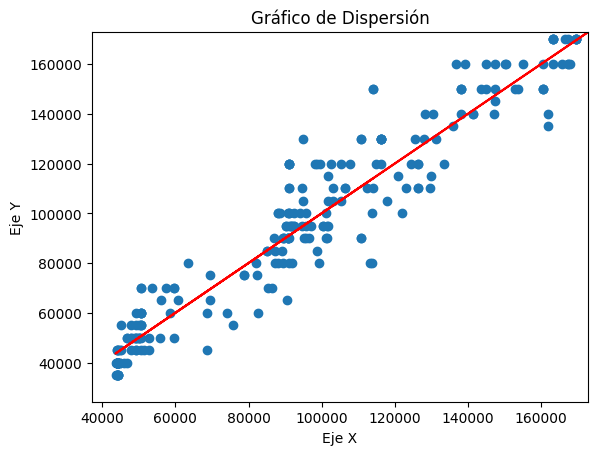

In [104]:
# Crear el gráfico de dispersión
plt.scatter(y_test_pred, y_test)
plt.plot(y_test_pred, y_test_pred, color='red')

# Establecer el límite del eje Y como el máximo valor en el eje X
plt.xlim(plt.xlim()[0], np.max(y_test_pred))
plt.ylim(plt.ylim()[0], np.max(y_test_pred))

# Personalizar el gráfico
plt.title('Gráfico de Dispersión')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')

In [106]:
# Calcular las métricas de regresión
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = mean_squared_error(y_test, y_test_pred, squared=False)
r2 = r2_score(y_test, y_test_pred)



In [108]:
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R^2:", r2)

MAE: 9392.081736909324
MSE: 170194338.0161771
RMSE: 13045.855204476902
R^2: 0.9183679193438627
